# Power Ratings Process

## Data Prep

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime
import pytz
warnings.filterwarnings("ignore")

cst = pytz.timezone('America/Chicago')
formatted_date = datetime.now(cst).strftime('%m_%d_%Y')
current_season = datetime.today().year

def PEAR_Win_Prob(home_pr, away_pr):
    rating_diff = home_pr - away_pr
    win_prob = round(1 / (1 + 10 ** (-rating_diff / 7.5)) * 100, 2)
    return win_prob

# Base URL for NCAA stats
base_url = "https://www.ncaa.com"
stats_page = f"{base_url}/stats/baseball/d1"

# Function to get page content
def get_soup(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    response.raise_for_status()  # Ensure request was successful
    return BeautifulSoup(response.text, "html.parser")

# Get main page content
soup = get_soup(stats_page)

# Find the dropdown container and extract stat URLs
dropdown = soup.find("select", {"id": "select-container-team"})
options = dropdown.find_all("option")

# Extract stat names and links
stat_links = {
    option.text.strip(): base_url + option["value"]
    for option in options if option.get("value")
}

url = "https://www.ncaa.com/rankings/baseball/d1/rpi"
response = requests.get(url)
response.raise_for_status()  # Ensure request was successful
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find("table", class_="sticky")
if table:
    headers = [th.text.strip() for th in table.find_all("th")]
    data = []
    for row in table.find_all("tr")[1:]:  # Skip header row
        cols = row.find_all("td")
        data.append([col.text.strip() for col in cols])
    rpi = pd.DataFrame(data, columns=headers)
    rpi = rpi.drop(columns = ['Previous'])
    rpi.rename(columns={"School": "Team"}, inplace=True)
else:
    print("Table not found.")

url = 'https://www.warrennolan.com/baseball/2025/rpi-predict'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', class_='normal-grid alternating-rows stats-table')
headers = [th.text.strip() for th in table.find('thead').find_all('th')]

data = []
for row in table.find('tbody').find_all('tr'):
    cells = row.find_all('td')
    if len(cells) >= 2:
        rank = cells[0].text.strip()  # First element (ranking)
        name_div = cells[1].find('div', class_='name-subcontainer')
        if name_div:
            full_text = name_div.text.strip()
        else:
            full_text = cells[1].text.strip()  # Fallback
        
        # Split the text to extract Team Name and Conference
        parts = full_text.split("\n")
        team_name = parts[0].strip()  # Extract just the team name
        conference = parts[1].split("(")[0].strip() if len(parts) > 1 else ""  # Extract conference
        data.append([rank, team_name, conference]) 
projected_rpi = pd.DataFrame(data, columns=["RPI", "Team", "Conference"])

team_replacements = {
    'North Carolina St.': 'NC State',
    'Southern Miss': 'Southern Miss.',
    'USC': 'Southern California',
    'Dallas Baptist': 'DBU',
    'Charleston': 'Col. of Charleston',
    'Georgia Southern': 'Ga. Southern',
    'UNCG': 'UNC Greensboro',
    'East Tennessee St.': 'ETSU',
    'Lamar': 'Lamar University',
    "Saint Mary's College": "Saint Mary's (CA)",
    'Western Kentucky': 'Western Ky.',
    'FAU': 'Fla. Atlantic',
    'Connecticut': 'UConn',
    'Southeast Missouri': 'Southeast Mo. St.',
    'Alcorn St.': 'Alcorn',
    'Appalachian St.': 'App State',
    'Arkansas-Pine Bluff': 'Ark.-Pine Bluff',
    'Army': 'Army West Point',
    'Cal St. Bakersfield': 'CSU Bakersfield',
    'Cal St. Northridge': 'CSUN',
    'Central Arkansas': 'Central Ark.',
    'Central Michigan': 'Central Mich.',
    'Charleston Southern': 'Charleston So.',
    'Eastern Illinois': 'Eastern Ill.',
    'Eastern Kentucky': 'Eastern Ky.',
    'Eastern Michigan': 'Eastern Mich.',
    'Fairleigh Dickinson': 'FDU',
    'Grambling St.': 'Grambling',
    'Incarnate Word': 'UIW',
    'Long Island': 'LIU',
    'Maryland Eastern Shore': 'UMES',
    'Middle Tennessee': 'Middle Tenn.',
    'Mississippi Valley St.': 'Mississippi Val.',
    "Mount Saint Mary's": "Mount St. Mary's",
    'North Alabama': 'North Ala.',
    'North Carolina A&T': 'N.C. A&T',
    'Northern Colorado': 'Northern Colo.',
    'Northern Kentucky': 'Northern Ky.',
    'Prairie View A&M': 'Prairie View',
    'Presbyterian College': 'Presbyterian',
    'Saint Bonaventure': 'St. Bonaventure',
    "Saint John's": "St. John's (NY)",
    'Sam Houston St.': 'Sam Houston',
    'Seattle University': 'Seattle U',
    'South Carolina Upstate': 'USC Upstate',
    'South Florida': 'South Fla.',
    'Southeastern Louisiana': 'Southeastern La.',
    'Southern': 'Southern U.',
    'Southern Illinois': 'Southern Ill.',
    'Stephen F. Austin': 'SFA',
    'Tennessee-Martin': 'UT Martin',
    'Texas A&M-Corpus Christi': 'A&M-Corpus Christi',
    'UMass-Lowell': 'UMass Lowell',
    'UTA': 'UT Arlington',
    'Western Carolina': 'Western Caro.',
    'Western Illinois': 'Western Ill.',
    'Western Michigan': 'Western Mich.',
}

projected_rpi['Team'] = projected_rpi['Team'].str.replace('State', 'St.', regex=False)
projected_rpi['Team'] = projected_rpi['Team'].replace(team_replacements)

In [2]:
def get_stat_dataframe(stat_name):
    """Fetches the specified stat table from multiple pages and returns a combined DataFrame,
    keeps 'Team' as string, and converts all other columns to float."""
    
    if stat_name not in stat_links:
        print(f"Stat '{stat_name}' not found. Available stats: {list(stat_links.keys())}")
        return None
    
    # Initialize the DataFrame to store all pages' data
    all_data = []
    page_num = 1  # Start from the first page

    while True:
        url = stat_links[stat_name]
        if page_num > 1:
            # Modify the URL to include the page number
            url = f"{url}/p{page_num}"
        
        # print(f"Fetching data for: {stat_name} (Page {page_num} - {url})")

        try:
            # Get stats page content
            soup = get_soup(url)

            # Locate table
            table = soup.find("table")
            if not table:
                print(f"No table found for {stat_name} on page {page_num}")
                break  # Exit the loop if no table is found (end of valid pages)

            # Extract table headers
            headers = [th.text.strip() for th in table.find_all("th")]

            # Extract table rows
            data = []
            for row in table.find_all("tr")[1:]:  # Skip header row
                cols = row.find_all("td")
                data.append([col.text.strip() for col in cols])

            all_data.extend(data)  # Add the data from this page to the list of all data
        
        except requests.exceptions.HTTPError as e:
            print(f"{stat_name} Done")
            break  # Exit the loop on HTTPError (page doesn't exist)
        except Exception as e:
            print(f"An error occurred: {e}")
            break  # Exit the loop on any other error

        page_num += 1  # Go to the next page

    # Convert to DataFrame
    if all_data:
        df = pd.DataFrame(all_data, columns=headers)

        # Convert all columns to float except "Team"
        for col in df.columns:
            if col != "Team":
                df[col] = pd.to_numeric(df[col], errors="coerce")  # Converts to float, invalid values become NaN

        return df
    else:
        print("No data collected.")
        return None

# Example usage
stat_name_input = "Batting Average"  # Change this to the desired stat
ba = get_stat_dataframe(stat_name_input)
ba["HPG"] = ba["H"] / ba["G"]
ba["ABPG"] = ba["AB"] / ba["G"]
ba["HPAB"] = ba["H"] / ba["AB"]
ba = ba.drop(columns=['Rank'])

stat_name_input = "Base on Balls"
bb = get_stat_dataframe(stat_name_input)
bb["BBPG"] = bb["BB"] / bb["G"]
bb = bb.drop(columns=['Rank', 'G'])

stat_name_input = "Double Plays Per Game"
dp = get_stat_dataframe(stat_name_input)
dp.rename(columns={"PG": "DPPG"}, inplace=True)
dp = dp.drop(columns=['Rank', 'G'])

stat_name_input = "Earned Run Average"
era = get_stat_dataframe(stat_name_input)
era.rename(columns={"R":"RA"}, inplace=True)
era = era.drop(columns=['Rank', 'G'])

stat_name_input = "Fielding Percentage"
fp = get_stat_dataframe(stat_name_input)
fp["APG"] = fp["A"] / fp["G"]
fp["EPG"] = fp["E"] / fp["G"]
fp = fp.drop(columns=['Rank', 'G'])

stat_name_input = "Hits Allowed Per Nine Innings"
ha = get_stat_dataframe(stat_name_input)
ha.rename(columns={"PG": "HAPG"}, inplace=True)
ha = ha.drop(columns=['Rank', 'G', 'IP'])

stat_name_input = "Home Runs Per Game"
hr = get_stat_dataframe(stat_name_input)
hr.rename(columns={"PG": "HRPG"}, inplace=True)
hr = hr.drop(columns=['Rank', 'G'])
duplicate_teams = hr[hr.duplicated('Team', keep=False)]
filtered_teams = duplicate_teams.loc[duplicate_teams.groupby('Team')["HR"].idxmin()]
hr_cleaned = hr[~hr["Team"].isin(duplicate_teams["Team"])]
hr = pd.concat([hr_cleaned, filtered_teams], ignore_index=True)

stat_name_input = "On Base Percentage"
obp = get_stat_dataframe(stat_name_input)
obp.rename(columns={"PCT": "OBP"}, inplace=True)
obp["HBPPG"] = obp["HBP"] / obp["G"]
obp = obp.drop(columns=['Rank', 'G', 'AB', 'H', 'BB', 'SF', 'SH'])

stat_name_input = "Runs"
runs = get_stat_dataframe(stat_name_input)
runs["RPG"] = runs["R"] / runs["G"]
runs.rename(columns={"R": "RS"}, inplace=True)
runs = runs.drop(columns=['Rank', 'G'])

stat_name_input = "Sacrifice Bunts"
sb = get_stat_dataframe(stat_name_input)
sb.rename(columns={"SH": "SB"}, inplace=True)
sb["SBPG"] = sb["SB"] / sb["G"]
sb = sb.drop(columns=['Rank', 'G'])

stat_name_input = "Sacrifice Flies"
sf = get_stat_dataframe(stat_name_input)
sf["SFPG"] = sf["SF"] / sf["G"]
sf = sf.drop(columns=['Rank', 'G'])

stat_name_input = "Slugging Percentage"
slg = get_stat_dataframe(stat_name_input)
slg.rename(columns={"SLG PCT": "SLG"}, inplace=True)
slg = slg.drop(columns=['Rank', 'G', 'AB'])

stat_name_input = "Stolen Bases"
stl = get_stat_dataframe(stat_name_input)
stl["STLP"] = stl["SB"] / (stl["SB"] + stl["CS"])
stl["STLPG"] = stl["SB"] / stl["G"]
stl["CSPG"] = stl["CS"] / stl["G"]
stl["SAPG"] = (stl["SB"] + stl["CS"]) / stl["G"]
stl.rename(columns={"SB": "STL"}, inplace=True)
stl = stl.drop(columns=['Rank', 'G'])

stat_name_input = "Strikeout-to-Walk Ratio"
kbb = get_stat_dataframe(stat_name_input)
kbb["IP"] = round(kbb["IP"])
kbb.rename(columns={"K/BB": "KBB"}, inplace=True)
kbb.rename(columns={"BB": "PBB"}, inplace=True)
kbb = kbb.drop(columns=['Rank', 'App', 'IP'])

stat_name_input = "Strikeouts Per Nine Innings"
kp9 = get_stat_dataframe(stat_name_input)
kp9.rename(columns={"K/9": "KP9"}, inplace=True)
kp9 = kp9.drop(columns=['Rank', 'G', 'IP', 'SO'])

stat_name_input = "Walks Allowed Per Nine Innings"
wp9 = get_stat_dataframe(stat_name_input)
wp9.rename(columns={"PG": "WP9"}, inplace=True)
wp9 = wp9.drop(columns=['Rank', 'G', 'IP', 'BB'])

stat_name_input = "WHIP"
whip = get_stat_dataframe(stat_name_input)
whip = whip.drop(columns=['Rank', 'HA', 'IP', 'BB'])

dfs = [ba, bb, era, fp, obp, runs, slg, kp9, wp9, whip, projected_rpi]
for df in dfs:
    df["Team"] = df["Team"].str.strip()
df_combined = dfs[0]
for df in dfs[1:]:
    df_combined = pd.merge(df_combined, df, on="Team", how="inner")
baseball_stats = df_combined.loc[:, ~df_combined.columns.duplicated()].sort_values('Team').reset_index(drop=True)
baseball_stats['OPS'] = baseball_stats['SLG'] + baseball_stats['OBP']
baseball_stats['PYTHAG'] = (baseball_stats['RS'] ** 1.83) / ((baseball_stats['RS'] ** 1.83) + (baseball_stats['RA'] ** 1.83))

Batting Average Done
Base on Balls Done
Double Plays Per Game Done
Earned Run Average Done
Fielding Percentage Done
Hits Allowed Per Nine Innings Done
Home Runs Per Game Done
On Base Percentage Done
Runs Done
Sacrifice Bunts Done
Sacrifice Flies Done
Slugging Percentage Done
Stolen Bases Done
Strikeout-to-Walk Ratio Done
Strikeouts Per Nine Innings Done
Walks Allowed Per Nine Innings Done
WHIP Done


## PEAR Modeling

In [3]:
rpi_2024 = pd.read_csv("./PEAR/PEAR Baseball/rpi_end_2024.csv")

modeling_stats = baseball_stats[['Team', 'HPG',
                'BBPG', 'ERA', 'PCT', 
                'KP9', 'WP9', 'OPS', 
                'WHIP', 'PYTHAG', 'RPI']]
modeling_stats = pd.merge(modeling_stats, rpi_2024[['Team', 'Rank']], on = 'Team', how='left')
modeling_stats["Rank"] = modeling_stats["Rank"].apply(pd.to_numeric, errors='coerce')
modeling_stats["RPI"] = modeling_stats["RPI"].apply(pd.to_numeric, errors='coerce')
modeling_stats['Rank_pct'] = 1 - (modeling_stats['Rank'] - 1) / (len(modeling_stats) - 1)

higher_better = ["HPG", "BBPG", "PCT", "KP9", "OPS", "Rank_pct", 'PYTHAG']
lower_better = ["ERA", "WP9", "WHIP"]

scaler = MinMaxScaler(feature_range=(1, 100))
modeling_stats[higher_better] = scaler.fit_transform(modeling_stats[higher_better])
modeling_stats[lower_better] = scaler.fit_transform(-modeling_stats[lower_better])
weights = {
    'HPG': 8, 'BBPG': 8, 'ERA': 22, 'PCT': 8,
    'KP9': 8, 'WP9': 8, 'OPS': 22, 'WHIP': 8, 'PYTHAG': 22, 'Rank_pct': 50
}
modeling_stats['in_house_pr'] = sum(modeling_stats[stat] * weight for stat, weight in weights.items())

In [4]:
modeling_stats['in_house_pr'] = modeling_stats['in_house_pr'] - modeling_stats['in_house_pr'].mean()
current_range = modeling_stats['in_house_pr'].max() - modeling_stats['in_house_pr'].min()
desired_range = 25
scaling_factor = desired_range / current_range
modeling_stats['in_house_pr'] = round(modeling_stats['in_house_pr'] * scaling_factor, 4)
modeling_stats['in_house_pr'] = modeling_stats['in_house_pr'] - modeling_stats['in_house_pr'].min()

In [5]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from scipy.optimize import differential_evolution
from tqdm import tqdm
pbar = tqdm(total=500, desc="Optimization Progress")
def progress_callback(xk, convergence):
    """Callback to update the progress bar after each iteration."""
    pbar.update(1)
    if convergence < 1e-4:  # Close bar if convergence is achieved early
        pbar.close()

def objective_function(weights):
    (w_hpb, w_bbpg, w_era, w_pct, w_kp9, w_wp9, w_whip, w_ops, w_pythag, w_in_house_pr) = weights
    
    modeling_stats['power_ranking'] = (
        w_hpb * modeling_stats['HPG'] +
        w_bbpg * modeling_stats['BBPG'] +
        w_era * modeling_stats['ERA'] +
        w_pct * modeling_stats['PCT'] +
        w_kp9 * modeling_stats['KP9'] +
        w_wp9 * modeling_stats['WP9'] +
        w_whip * modeling_stats['WHIP'] +
        w_ops * modeling_stats['OPS'] +
        w_pythag * modeling_stats['PYTHAG'] + 
        w_in_house_pr * modeling_stats['in_house_pr']
    )

    modeling_stats['calculated_rank'] = modeling_stats['power_ranking'].rank(ascending=False)
    modeling_stats['combined_rank'] = (
        modeling_stats['RPI']
    )
    spearman_corr = modeling_stats[['calculated_rank', 'combined_rank']].corr(method='spearman').iloc[0,1]

    return -spearman_corr

bounds = [(-1,1),
          (-1,1),
          (-1,1),
          (-1,1),
          (-1,1),
          (-1,1),
          (-1,1),
          (-1,1),
          (-1,1),
          (0,1)]
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=500, tol=1e-4, seed=42, callback=progress_callback)
optimized_weights = result.x
modeling_stats = modeling_stats.sort_values('power_ranking', ascending=False).reset_index(drop=True)

Optimization Progress:  39%|███▊      | 193/500 [01:05<01:37,  3.16it/s]

In [6]:
modeling_stats['Rating'] = modeling_stats['power_ranking'] - modeling_stats['power_ranking'].mean()
current_range = modeling_stats['Rating'].max() - modeling_stats['Rating'].min()
desired_range = 15
scaling_factor = desired_range / current_range
modeling_stats['Rating'] = round(modeling_stats['Rating'] * scaling_factor, 4)
modeling_stats['Rating'] = modeling_stats['Rating'] - modeling_stats['Rating'].min()
modeling_stats['Rating'] = round(modeling_stats['Rating'] - modeling_stats['Rating'].mean(),2)
modeling_stats['Rating'] = round(modeling_stats['Rating'], 2)

In [7]:
ending_data = pd.merge(baseball_stats, modeling_stats[['Team', 'Rating']], on="Team", how="inner").sort_values('Rating', ascending=False).reset_index(drop=True)
# ending_data = ending_data.drop(columns=['SOR', 'SOS'])
ending_data.index = ending_data.index + 1
# ending_data[['Wins', 'Losses']] = ending_data['Rec'].str.split('-', expand=True).astype(int)
# ending_data['WIN%'] = round(ending_data['Wins'] / (ending_data['Wins'] + ending_data['Losses']), 3)
# ending_data['Wins_Over_Pythag'] = ending_data['WIN%'] - ending_data['PYTHAG']

## Schedule Info Load

### Data Pull

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = 'https://www.warrennolan.com/baseball/2025/elo'

# Fetch the webpage content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table with the specified class
table = soup.find('table', class_='normal-grid alternating-rows stats-table')

if table:
    # Extract table headers
    headers = [th.text.strip() for th in table.find('thead').find_all('th')]
    headers.insert(1, "Team Link")  # Adding extra column for team link

    # Extract table rows
    data = []
    for row in table.find('tbody').find_all('tr'):
        cells = row.find_all('td')
        row_data = []
        for i, cell in enumerate(cells):
            # If it's the first cell, extract team name and link from 'name-subcontainer'
            if i == 0:
                name_container = cell.find('div', class_='name-subcontainer')
                if name_container:
                    team_name = name_container.text.strip()
                    team_link_tag = name_container.find('a')
                    team_link = team_link_tag['href'] if team_link_tag else ''
                else:
                    team_name = cell.text.strip()
                    team_link = ''
                row_data.append(team_name)
                row_data.append(team_link)  # Add team link separately
            else:
                row_data.append(cell.text.strip())
        data.append(row_data)


    elo_data = pd.DataFrame(data, columns=[headers])
    elo_data.columns = elo_data.columns.get_level_values(0)
    elo_data = elo_data.drop_duplicates(subset='Team', keep='first')
    elo_data = elo_data.astype({col: 'str' for col in elo_data.columns if col not in ['ELO', 'Rank']})
    elo_data['ELO'] = elo_data['ELO'].astype(float, errors='ignore')
    elo_data['Rank'] = elo_data['Rank'].astype(int, errors='ignore')

else:
    print("Table not found on the page.")

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Base URL for Warren Nolan
BASE_URL = "https://www.warrennolan.com"

# Initialize storage for schedule data
schedule_data = []

# Iterate over each team's schedule link
for _, row in elo_data.iterrows():
    team_name = row["Team"]
    print(team_name)
    team_schedule_url = BASE_URL + row["Team Link"]
    
    response = requests.get(team_schedule_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the team name
    # team_name = soup.find("h1").text.strip() if soup.find("h1") else "Unknown"

    # Find the team schedule list
    schedule_lists = soup.find_all("ul", class_="team-schedule")
    if not schedule_lists:
        continue  # Skip if no schedule is found

    schedule_list = schedule_lists[0]

    # Iterate over each game row in the schedule
    for game in schedule_list.find_all('li', class_='team-schedule'):
        # Extract Date
        date_month = game.find('span', class_='team-schedule__game-date--month').text.strip()
        date_day = game.find('span', class_='team-schedule__game-date--day').text.strip()
        date_dow = game.find('span', class_='team-schedule__game-date--dow').text.strip()
        game_date = f"{date_month} {date_day} ({date_dow})"

        # Extract Opponent Name (Handle missing cases)
        opponent_info = game.find('div', class_='team-schedule__opp')
        if opponent_info:
            opponent_link_element = opponent_info.find('a', class_='team-schedule__opp-line-link')
            opponent_name = opponent_link_element.text.strip() if opponent_link_element else ""
        else:
            opponent_name = ""

        # Extract Location
        location_info = game.find('div', class_='team-schedule__info')
        location = location_info.text.strip() if location_info else "Unknown"

        # Extract Game Result
        result_info = game.find('div', class_='team-schedule__result')
        result_text = result_info.text.strip() if result_info else "N/A"

        # Extract Home/Away Teams from Box Score and scores
        home_score, away_score = "", ""  # Initialize scores as empty strings

        box_score_table = game.find('table', class_='team-schedule-bottom__box-score')
        if box_score_table:
            rows = box_score_table.find_all('tr')
            if len(rows) > 2:
                away_team = rows[1].find_all('td')[0].text.strip()
                home_team = rows[2].find_all('td')[0].text.strip()

                # Extracting Runs
                away_score = rows[1].find_all('td')[-3].text.strip()  # Away runs
                home_score = rows[2].find_all('td')[-3].text.strip()  # Home runs
            else:
                home_team, away_team = "N/A", "N/A"
        else:
            home_team, away_team = "N/A", "N/A"

        # Append to schedule data
        schedule_data.append([team_name, game_date, opponent_name, location, result_text, home_team, away_team, home_score, away_score])

# Convert to DataFrame
columns = ["Team", "Date", "Opponent", "Location", "Result", "home_team", "away_team", "home_score", "away_score"]
schedule_df = pd.DataFrame(schedule_data, columns=columns)
schedule_df = schedule_df.astype({col: 'str' for col in schedule_df.columns if col not in ['home_score', 'away_score']})
schedule_df['home_score'] = schedule_df['home_score'].astype(int, errors='ignore')
schedule_df['away_score'] = schedule_df['away_score'].astype(int, errors='ignore')
schedule_df = schedule_df.merge(elo_data[['Team', 'ELO']], left_on='home_team', right_on='Team', how='left')
schedule_df.rename(columns={'ELO': 'home_elo'}, inplace=True)
schedule_df = schedule_df.merge(elo_data[['Team', 'ELO']], left_on='away_team', right_on='Team', how='left')
schedule_df.rename(columns={'ELO': 'away_elo'}, inplace=True)
schedule_df.drop(columns=['Team', 'Team_y'], inplace=True)
schedule_df.rename(columns={'Team_x':'Team'}, inplace=True)

Tennessee
North Carolina
Florida State
Texas A&M
Arkansas
Florida
Georgia
LSU
Oregon State
Vanderbilt
Virginia
Clemson
Wake Forest
Oregon
Mississippi State
Oklahoma
Texas
Duke
UC Santa Barbara
Alabama
South Carolina
Dallas Baptist
TCU
Southern Miss
West Virginia
Hawaii
Kansas
Troy
Arizona
Auburn
Arizona State
Oklahoma State
USC
Coastal Carolina
Louisville
Georgia Tech
High Point
Wofford
UCF
Miami (FL)
North Carolina State
Charleston
Kentucky
UNCW
Ole Miss
Tulane
Louisiana Tech
Kansas State
Illinois
Cincinnati
Purdue
UC Irvine
Lamar
Louisiana
UNCG
Penn State
Western Kentucky
Notre Dame
Stanford
Nebraska
California
Michigan
Indiana State
Northeastern
East Tennessee State
Pittsburgh
James Madison
Grand Canyon
Georgia Southern
Nicholls
Utah
Xavier
Virginia Tech
Michigan State
McNeese
FAU
Stetson
San Jose State
Murray State
Houston
Liberty
Texas State
UCLA
UAB
East Carolina
Creighton
Baylor
Appalachian State
UTSA
Saint Mary's College
FIU
Mercer
Iowa
FGCU
Samford
Cal Poly
Old Dominion
Portla

### Data Formatting

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = 'https://www.warrennolan.com/baseball/2025/elo'

# Fetch the webpage content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table with the specified class
table = soup.find('table', class_='normal-grid alternating-rows stats-table')

if table:
    # Extract table headers
    headers = [th.text.strip() for th in table.find('thead').find_all('th')]
    headers.insert(1, "Team Link")  # Adding extra column for team link

    # Extract table rows
    data = []
    for row in table.find('tbody').find_all('tr'):
        cells = row.find_all('td')
        row_data = []
        for i, cell in enumerate(cells):
            # If it's the first cell, extract team name and link from 'name-subcontainer'
            if i == 0:
                name_container = cell.find('div', class_='name-subcontainer')
                if name_container:
                    team_name = name_container.text.strip()
                    team_link_tag = name_container.find('a')
                    team_link = team_link_tag['href'] if team_link_tag else ''
                else:
                    team_name = cell.text.strip()
                    team_link = ''
                row_data.append(team_name)
                row_data.append(team_link)  # Add team link separately
            else:
                row_data.append(cell.text.strip())
        data.append(row_data)


    elo_data = pd.DataFrame(data, columns=[headers])
    elo_data.columns = elo_data.columns.get_level_values(0)
    elo_data = elo_data.drop_duplicates(subset='Team', keep='first')
    elo_data = elo_data.astype({col: 'str' for col in elo_data.columns if col not in ['ELO', 'Rank']})
    elo_data['ELO'] = elo_data['ELO'].astype(float, errors='ignore')
    elo_data['Rank'] = elo_data['Rank'].astype(int, errors='ignore')

else:
    print("Table not found on the page.")

# Define mapping for team name replacements
team_replacements = {
    'North Carolina St.': 'NC State',
    'Southern Miss': 'Southern Miss.',
    'USC': 'Southern California',
    'Dallas Baptist': 'DBU',
    'Charleston': 'Col. of Charleston',
    'Georgia Southern': 'Ga. Southern',
    'UNCG': 'UNC Greensboro',
    'East Tennessee St.': 'ETSU',
    'Lamar': 'Lamar University',
    "Saint Mary's College": "Saint Mary's (CA)",
    'Western Kentucky': 'Western Ky.',
    'FAU': 'Fla. Atlantic',
    'Connecticut': 'UConn',
    'Southeast Missouri': 'Southeast Mo. St.',
    'Alcorn St.': 'Alcorn',
    'Appalachian St.': 'App State',
    'Arkansas-Pine Bluff': 'Ark.-Pine Bluff',
    'Army': 'Army West Point',
    'Cal St. Bakersfield': 'CSU Bakersfield',
    'Cal St. Northridge': 'CSUN',
    'Central Arkansas': 'Central Ark.',
    'Central Michigan': 'Central Mich.',
    'Charleston Southern': 'Charleston So.',
    'Eastern Illinois': 'Eastern Ill.',
    'Eastern Kentucky': 'Eastern Ky.',
    'Eastern Michigan': 'Eastern Mich.',
    'Fairleigh Dickinson': 'FDU',
    'Grambling St.': 'Grambling',
    'Incarnate Word': 'UIW',
    'Long Island': 'LIU',
    'Maryland Eastern Shore': 'UMES',
    'Middle Tennessee': 'Middle Tenn.',
    'Mississippi Valley St.': 'Mississippi Val.',
    "Mount Saint Mary's": "Mount St. Mary's",
    'North Alabama': 'North Ala.',
    'North Carolina A&T': 'N.C. A&T',
    'Northern Colorado': 'Northern Colo.',
    'Northern Kentucky': 'Northern Ky.',
    'Prairie View A&M': 'Prairie View',
    'Presbyterian College': 'Presbyterian',
    'Saint Bonaventure': 'St. Bonaventure',
    "Saint John's": "St. John's (NY)",
    'Sam Houston St.': 'Sam Houston',
    'Seattle University': 'Seattle U',
    'South Carolina Upstate': 'USC Upstate',
    'South Florida': 'South Fla.',
    'Southeastern Louisiana': 'Southeastern La.',
    'Southern': 'Southern U.',
    'Southern Illinois': 'Southern Ill.',
    'Stephen F. Austin': 'SFA',
    'Tennessee-Martin': 'UT Martin',
    'Texas A&M-Corpus Christi': 'A&M-Corpus Christi',
    'UMass-Lowell': 'UMass Lowell',
    'UTA': 'UT Arlington',
    'Western Carolina': 'Western Caro.',
    'Western Illinois': 'Western Ill.',
    'Western Michigan': 'Western Mich.',
}

# Apply replacements and standardize 'State' to 'St.'
columns_to_replace = ['Team', 'home_team', 'away_team', 'Opponent']

for col in columns_to_replace:
    schedule_df[col] = schedule_df[col].str.replace('State', 'St.', regex=False)
    schedule_df[col] = schedule_df[col].replace(team_replacements)
elo_data['Team'] = elo_data['Team'].str.replace('State', 'St.', regex=False)
elo_data['Team'] = elo_data['Team'].replace(team_replacements)

## Metric Calculations

In [11]:
import pandas as pd

# Mapping months to numerical values
month_mapping = {
    "JAN": "01", "FEB": "02", "MAR": "03", "APR": "04",
    "MAY": "05", "JUN": "06", "JUL": "07", "AUG": "08",
    "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"
}

current_season = 2025  # Set the current season

# Function to convert "FEB 14 (FRI)" format to "mm-dd-yyyy"
def convert_date(date_str):
    # Ensure date is a string before splitting
    if isinstance(date_str, pd.Timestamp):
        date_str = date_str.strftime("%b %d (%a)").upper()  # Convert to same format
    
    parts = date_str.split()  # ["FEB", "14", "(FRI)"]
    month = month_mapping[parts[0].upper()]  # Convert month to number
    day = parts[1]  # Extract day
    return f"{month}-{day}-{current_season}"

# Apply function to convert date format
schedule_df["Date"] = schedule_df["Date"].astype(str).apply(convert_date)
schedule_df["Date"] = pd.to_datetime(schedule_df["Date"], format="%m-%d-%Y")
comparison_date = pd.to_datetime(formatted_date, format="%m_%d_%Y")

missing_rating = round(ending_data['Rating'].mean() - 1.5*ending_data['Rating'].std(),2)
schedule_df = schedule_df.merge(ending_data[['Team', 'Rating']], left_on='home_team', right_on='Team', how='left')
schedule_df.rename(columns={'Rating': 'home_rating'}, inplace=True)
schedule_df = schedule_df.merge(ending_data[['Team', 'Rating']], left_on='away_team', right_on='Team', how='left')
schedule_df.rename(columns={'Rating': 'away_rating'}, inplace=True)
schedule_df.drop(columns=['Team', 'Team_y'], inplace=True)
schedule_df.rename(columns={'Team_x':'Team'}, inplace=True)
schedule_df['home_rating'].fillna(missing_rating, inplace=True)
schedule_df['away_rating'].fillna(missing_rating, inplace=True)
schedule_df['home_win_prob'] = schedule_df.apply(
    lambda row: PEAR_Win_Prob(row['home_rating'], row['away_rating']) / 100, axis=1
)
completed_schedule = schedule_df[
    (schedule_df["Date"] <= comparison_date) & (schedule_df["home_score"] != schedule_df["away_score"])
].reset_index(drop=True)
completed_schedule = completed_schedule[completed_schedule["Result"].str.startswith(("W", "L"))]
remaining_games = schedule_df[schedule_df["Date"] > comparison_date].reset_index(drop=True)

def adjust_home_pr(home_win_prob):
    return ((home_win_prob - 50) / 50) * 1.5
schedule_df['elo_win_prob'] = round((10**((schedule_df['home_elo'] - schedule_df['away_elo']) / 400)) / ((10**((schedule_df['home_elo'] - schedule_df['away_elo']) / 400)) + 1)*100,2)
schedule_df['Spread'] = (schedule_df['home_rating'] + (schedule_df['elo_win_prob'].apply(adjust_home_pr)) - schedule_df['away_rating']).round(2)
schedule_df['PEAR'] = schedule_df.apply(
    lambda row: f"{row['away_team']} {-abs(row['Spread'])}" if ((row['Spread'] <= 0)) 
    else f"{row['home_team']} {-abs(row['Spread'])}", axis=1)

In [12]:
def calculate_expected_wins(group):
    # Initialize a variable to accumulate expected wins
    expected_wins = 0
    schedule_wins = 0
    schedule_losses = 0
    
    # Iterate over the rows of the group
    for _, row in group.iterrows():
        if row['Team'] == row['home_team']:
            expected_wins += row['home_win_prob']
            if row['home_score'] > row['away_score']:
                schedule_wins += 1
            else:
                schedule_losses += 1
        else:
            expected_wins += 1 - row['home_win_prob']
            if row['away_score'] > row['home_score']:
                schedule_wins += 1
            else:
                schedule_losses += 1
    
    # Return the total expected_wins for this group
    return pd.Series({'Team': group['Team'].iloc[0], 'expected_wins': expected_wins, 'Wins':schedule_wins, 'Losses':schedule_losses})

# Group by 'Team' and apply the calculation
team_expected_wins = completed_schedule.groupby('Team').apply(calculate_expected_wins).reset_index(drop=True)

In [13]:
def calculate_average_expected_wins(group, average_team):
    total_expected_wins = 0

    for _, row in group.iterrows():
        if row['Team'] == row['home_team']:
            total_expected_wins += PEAR_Win_Prob(average_team, row['away_rating']) / 100
        else:
            total_expected_wins += 1 - PEAR_Win_Prob(row['home_rating'], average_team) / 100

    avg_expected_wins = total_expected_wins / len(group)

    return pd.Series({'Team': group['Team'].iloc[0], 'avg_expected_wins': avg_expected_wins, 'total_expected_wins':total_expected_wins})

average_team = ending_data['Rating'].mean()
avg_team_expected_wins = completed_schedule.groupby('Team').apply(calculate_average_expected_wins, average_team).reset_index(drop=True)

rem_avg_expected_wins = remaining_games.groupby('Team').apply(calculate_average_expected_wins, average_team).reset_index(drop=True)
rem_avg_expected_wins.rename(columns={"avg_expected_wins": "rem_avg_expected_wins", "total_expected_wins":"rem_total_expected_wins"}, inplace=True)

In [ ]:
# quadrant_records = {}

# for team, group in completed_schedule.groupby('Team'):
#     Q1_win, Q1_loss = 0, 0  # Initialize counters
#     Q2_win, Q2_loss = 0, 0
#     Q3_win, Q3_loss = 0, 0
#     Q4_win, Q4_loss = 0, 0

#     for _, row in group.iterrows():
#         opponent = row['Opponent']
        
#         if len(ending_data[ending_data['Team'] == opponent]) > 0:
#             opponent_index = ending_data[ending_data['Team'] == opponent].index.values[0]
#         else:
#             opponent_index = 300

#         team_is_home = row['Team'] == row['home_team']
#         team_won = (row['home_score'] > row['away_score'] and team_is_home) or \
#                     (row['away_score'] > row['home_score'] and not team_is_home)

#         # Apply quadrant logic
#         if opponent_index <= 40:
#             if team_won:
#                 Q1_win += 1
#             else:
#                 Q1_loss += 1
#         elif opponent_index <= 80:
#             if team_won:
#                 Q2_win += 1
#             else:
#                 Q2_loss += 1
#         elif opponent_index <= 160:
#             if team_won:
#                 Q3_win += 1
#             else:
#                 Q3_loss += 1
#         else:
#             if team_won:
#                 Q4_win += 1
#             else:
#                 Q4_loss += 1            
            

#     # Store results for the team
#     quadrant_records[team] = {'Team': team, 'Q1': f"{Q1_win}-{Q1_loss}", 'Q2': f"{Q2_win}-{Q2_loss}", 'Q3': f"{Q3_win}-{Q3_loss}", 'Q4': f"{Q4_win}-{Q4_loss}"}
# quadrant_record_df = pd.DataFrame.from_dict(quadrant_records, orient='index').reset_index(drop=True)

In [14]:
def calculate_kpi(completed_schedule, ending_data):
    def get_team_rank(team):
        match = ending_data.loc[ending_data["Team"] == team]
        return match.index[0] if not match.empty else len(ending_data) + 1

    def get_opponent_rank(opponent):
        match = ending_data.loc[ending_data["Team"] == opponent]
        return match.index[0] if not match.empty else len(ending_data) + 1

    kpi_scores = []

    for _, game in completed_schedule.iterrows():
        team = game["Team"]
        opponent = game["Opponent"]
        home_team = game["home_team"]
        
        # Team strength
        team_rank = get_team_rank(team)
        opponent_rank = get_opponent_rank(opponent)

        # Opponent strength calculation
        opponent_strength_win = 1 - (opponent_rank / (len(ending_data) + 1))
        opponent_strength_loss = (opponent_rank / (len(ending_data) + 1))
        
        # Determine if the team is home
        is_home = team == home_team
        
        # Scoring margin
        margin = game["home_score"] - game["away_score"]
        if not is_home:
            margin = -margin  # Flip if the team is away

        # Win or loss multiplier
        result_multiplier = 1.5 if margin > 0 else -1.5

        # Margin factor
        if margin > 0:
            margin_factor = 1 + (min(margin, 20) / 20)
            opponent_strength = opponent_strength_win
        else:
            margin_factor = max(0.1, 1 - (min(abs(margin), 20) / 20))
            opponent_strength = opponent_strength_loss

        # Team strength adjustment
        team_strength_adj = 1 - (team_rank / (len(ending_data) + 1))

        # Adjusted KPI formula
        adj_grv = (opponent_strength * result_multiplier * margin_factor / 1.5) * (1 + (team_strength_adj / 2))
        
        # Store result
        kpi_scores.append({"Team": team, "KPI_Score": adj_grv})

    # Convert to DataFrame and get average per team
    kpi_df = pd.DataFrame(kpi_scores)
    kpi_avg = kpi_df.groupby("Team")["KPI_Score"].mean().reset_index()

    return kpi_avg

# Call function
kpi_results = calculate_kpi(completed_schedule, ending_data).sort_values('KPI_Score', ascending=False).reset_index(drop=True)

In [15]:
def calculate_resume_quality(group, bubble_team_rating):
    results = []
    resume_quality = 0
    for _, row in group.iterrows():
        team = row['Team']
        is_home = row["home_team"] == team
        is_away = row["away_team"] == team
        opponent_rating = row["away_rating"] if is_home else row["home_rating"]
        win_prob = PEAR_Win_Prob(bubble_team_rating, opponent_rating) / 100
        team_won = (is_home and row["home_score"] > row["away_score"]) or (is_away and row["away_score"] > row["home_score"])
        if team_won:
            resume_quality += (1-win_prob)
        else:
            resume_quality -= win_prob
    results.append({"Team": team, "resume_quality": resume_quality})
    return pd.DataFrame(results)

In [16]:
df_1 = pd.merge(ending_data, team_expected_wins[['Team', 'expected_wins', 'Wins', 'Losses']], on='Team', how='left')
df_2 = pd.merge(df_1, avg_team_expected_wins[['Team', 'avg_expected_wins', 'total_expected_wins']], on='Team', how='left')
df_3 = pd.merge(df_2, rem_avg_expected_wins[['Team', 'rem_avg_expected_wins', 'rem_total_expected_wins']], on='Team', how='left')
df_4 = pd.merge(df_3, elo_data[['Team', 'ELO']], on='Team', how='left')
stats_and_metrics = pd.merge(df_4, kpi_results, on='Team', how='left')
# stats_and_metrics = pd.merge(df_5, quadrant_record_df, on='Team', how='left')

In [17]:
stats_and_metrics['wins_above_expected'] = round(stats_and_metrics['Wins'] - stats_and_metrics['total_expected_wins'],2)
stats_and_metrics['SOR'] = stats_and_metrics['wins_above_expected'].rank(method='min', ascending=False)
max_SOR = stats_and_metrics['SOR'].max()
stats_and_metrics['SOR'].fillna(max_SOR + 1, inplace=True)
stats_and_metrics['SOR'] = stats_and_metrics['SOR'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('SOR').reset_index(drop=True)

stats_and_metrics['RemSOS'] = stats_and_metrics['rem_avg_expected_wins'].rank(method='min', ascending=True)
max_remSOS = stats_and_metrics['RemSOS'].max()
stats_and_metrics['RemSOS'].fillna(max_remSOS + 1, inplace=True)
stats_and_metrics['RemSOS'] = stats_and_metrics['RemSOS'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('RemSOS').reset_index(drop=True)

stats_and_metrics['SOS'] = stats_and_metrics['avg_expected_wins'].rank(method='min', ascending=True)
max_SOS = stats_and_metrics['SOS'].max()
stats_and_metrics['SOS'].fillna(max_SOS + 1, inplace=True)
stats_and_metrics['SOS'] = stats_and_metrics['SOS'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('SOS').reset_index(drop=True)

stats_and_metrics['ELO'].fillna(1200, inplace=True)

In [18]:
bubble_rating = stats_and_metrics.loc[(stats_and_metrics["SOR"] >= 32) & (stats_and_metrics["SOR"] <= 40), "Rating"].mean()
bubble_expected_wins = completed_schedule.groupby('Team').apply(calculate_average_expected_wins, bubble_rating).reset_index(drop=True)
bubble_expected_wins.rename(columns={"avg_expected_wins": "bubble_expected_wins", "total_expected_wins":"bubble_total_expected_wins"}, inplace=True)

stats_and_metrics = pd.merge(stats_and_metrics, bubble_expected_wins, on='Team', how='left')

stats_and_metrics['wins_above_bubble'] = round(stats_and_metrics['Wins'] - stats_and_metrics['bubble_total_expected_wins'],2)
stats_and_metrics['Prelim_WAB'] = stats_and_metrics['wins_above_bubble'].rank(method='min', ascending=False)
max_WAB = stats_and_metrics['Prelim_WAB'].max()
stats_and_metrics['Prelim_WAB'].fillna(max_WAB + 1, inplace=True)
stats_and_metrics['Prelim_WAB'] = stats_and_metrics['Prelim_WAB'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('Prelim_WAB').reset_index(drop=True)

stats_and_metrics['KPI'] = stats_and_metrics['KPI_Score'].rank(method='min', ascending=False)
max_KPI = stats_and_metrics['KPI'].max()
stats_and_metrics['KPI'].fillna(max_KPI + 1, inplace=True)
stats_and_metrics['KPI'] = stats_and_metrics['KPI'].astype(int)

stats_and_metrics['Prelim_AVG'] = round(stats_and_metrics[['KPI', 'Prelim_WAB', 'SOR']].mean(axis=1),1)

bubble_rating = stats_and_metrics.loc[(stats_and_metrics['Prelim_AVG'] >= 32) & (stats_and_metrics['Prelim_AVG'] <= 40), "Rating"].mean()
bubble_expected_wins = completed_schedule.groupby('Team').apply(calculate_average_expected_wins, bubble_rating).reset_index(drop=True)
bubble_expected_wins.rename(columns={"avg_expected_wins": "final_bubble_expected_wins", "total_expected_wins":"final_bubble_total_expected_wins"}, inplace=True)
stats_and_metrics = pd.merge(stats_and_metrics, bubble_expected_wins, on='Team', how='left')

stats_and_metrics['wins_above_bubble'] = round(stats_and_metrics['Wins'] - stats_and_metrics['final_bubble_total_expected_wins'],2)
stats_and_metrics['WAB'] = stats_and_metrics['wins_above_bubble'].rank(method='min', ascending=False)
max_WAB = stats_and_metrics['WAB'].max()
stats_and_metrics['WAB'].fillna(max_WAB + 1, inplace=True)
stats_and_metrics['WAB'] = stats_and_metrics['WAB'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('WAB').reset_index(drop=True)

stats_and_metrics['AVG'] = round(stats_and_metrics[['KPI', 'WAB', 'SOR']].mean(axis=1),1)
stats_and_metrics['Resume'] = stats_and_metrics['AVG'].rank(method='min')

stats_and_metrics.fillna(0, inplace=True)
stats_and_metrics = stats_and_metrics.sort_values('Rating', ascending=False).reset_index(drop=True)
stats_and_metrics['Rating Rank'] = stats_and_metrics.index + 1

In [19]:
stats_and_metrics = stats_and_metrics.sort_values('Resume').reset_index(drop=True)
bubble_team_rating = stats_and_metrics.loc[33, 'Rating']
resume_quality = completed_schedule.groupby('Team').apply(calculate_resume_quality, bubble_team_rating).reset_index(drop=True)
resume_quality['RQI'] = resume_quality['resume_quality'].rank(method='min', ascending=False)
resume_quality = resume_quality.sort_values('RQI').reset_index(drop=True)
resume_quality['resume_quality'] = resume_quality['resume_quality'] - resume_quality.loc[33, 'resume_quality']

stats_and_metrics = pd.merge(stats_and_metrics, resume_quality, on='Team', how='left')

In [20]:
def calculate_NET(df, w1=0.45, w2=0.45, w3=0.1):

    df["Norm_Rating"] = (df["Rating"] - df["Rating"].min()) / (df["Rating"].max() - df["Rating"].min())
    df["Norm_RQI"] = (df["resume_quality"] - df["resume_quality"].min()) / (df["resume_quality"].max() - df["resume_quality"].min())
    df["Norm_SOS"] = (df["avg_expected_wins"] - df["avg_expected_wins"].min()) / (df["avg_expected_wins"].max() - df["avg_expected_wins"].min())
    df["NET_Score"] = (w1 * df["Norm_Rating"]) + (w2 * df["Norm_RQI"]) + (w3 * df["Norm_SOS"])
    df["NET"] = df["NET_Score"].rank(method="min", ascending=False)

    return df[["Team", "NET_Score", "NET"]].sort_values(by="NET").reset_index(drop=True)
net = calculate_NET(stats_and_metrics)

In [ ]:
quadrant_records = {}

for team, group in completed_schedule.groupby('Team'):
    Q1_win, Q1_loss = 0, 0  # Initialize counters
    Q2_win, Q2_loss = 0, 0
    Q3_win, Q3_loss = 0, 0
    Q4_win, Q4_loss = 0, 0

    for _, row in group.iterrows():
        opponent = row['Opponent']
        
        if len(stats_and_metrics[stats_and_metrics['Team'] == opponent]) > 0:
            opponent_index = stats_and_metrics[stats_and_metrics['Team'] == opponent]["NET"].values[0]
        else:
            opponent_index = 300

        team_is_home = row['Team'] == row['home_team']
        team_won = (row['home_score'] > row['away_score'] and team_is_home) or \
                    (row['away_score'] > row['home_score'] and not team_is_home)

        # Apply quadrant logic
        if opponent_index <= 40:
            if team_won:
                Q1_win += 1
            else:
                Q1_loss += 1
        elif opponent_index <= 80:
            if team_won:
                Q2_win += 1
            else:
                Q2_loss += 1
        elif opponent_index <= 160:
            if team_won:
                Q3_win += 1
            else:
                Q3_loss += 1
        else:
            if team_won:
                Q4_win += 1
            else:
                Q4_loss += 1            
            

    # Store results for the team
    quadrant_records[team] = {'Team': team, 'Q1': f"{Q1_win}-{Q1_loss}", 'Q2': f"{Q2_win}-{Q2_loss}", 'Q3': f"{Q3_win}-{Q3_loss}", 'Q4': f"{Q4_win}-{Q4_loss}"}
quadrant_record_df = pd.DataFrame.from_dict(quadrant_records, orient='index').reset_index(drop=True)
stats_and_metrics = pd.merge(stats_and_metrics, quadrant_record_df, on='Team', how='left')

## Live Schedule Load

In [4]:
from datetime import datetime # type: ignore
import os # type: ignore
import pandas as pd # type: ignore
import streamlit as st # type: ignore
import requests # type: ignore
from bs4 import BeautifulSoup # type: ignore
import pytz # type: ignore
import re # type: ignore
import numpy as np # type: ignore

cst = pytz.timezone('America/Chicago')
formatted_date = datetime.now(cst).strftime('%m_%d_%Y')
current_season = datetime.today().year

def elo_load():
    # URL of the page to scrape
    url = 'https://www.warrennolan.com/baseball/2025/elo'

    # Fetch the webpage content
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table with the specified class
    table = soup.find('table', class_='normal-grid alternating-rows stats-table')

    if table:
        # Extract table headers
        headers = [th.text.strip() for th in table.find('thead').find_all('th')]
        headers.insert(1, "Team Link")  # Adding extra column for team link

        # Extract table rows
        data = []
        for row in table.find('tbody').find_all('tr'):
            cells = row.find_all('td')
            row_data = []
            for i, cell in enumerate(cells):
                # If it's the first cell, extract team name and link from 'name-subcontainer'
                if i == 0:
                    name_container = cell.find('div', class_='name-subcontainer')
                    if name_container:
                        team_name = name_container.text.strip()
                        team_link_tag = name_container.find('a')
                        team_link = team_link_tag['href'] if team_link_tag else ''
                    else:
                        team_name = cell.text.strip()
                        team_link = ''
                    row_data.append(team_name)
                    row_data.append(team_link)  # Add team link separately
                else:
                    row_data.append(cell.text.strip())
            data.append(row_data)


        elo_data = pd.DataFrame(data, columns=[headers])
        elo_data.columns = elo_data.columns.get_level_values(0)
        elo_data = elo_data.drop_duplicates(subset='Team', keep='first')
        elo_data = elo_data.astype({col: 'str' for col in elo_data.columns if col not in ['ELO', 'Rank']})
        elo_data['ELO'] = elo_data['ELO'].astype(float, errors='ignore')
        elo_data['Rank'] = elo_data['Rank'].astype(int, errors='ignore')

    else:
        print("Table not found on the page.")

    # Define mapping for team name replacements
    team_replacements = {
        'North Carolina St.': 'NC State',
        'Southern Miss': 'Southern Miss.',
        'USC': 'Southern California',
        'Dallas Baptist': 'DBU',
        'Charleston': 'Col. of Charleston',
        'Georgia Southern': 'Ga. Southern',
        'UNCG': 'UNC Greensboro',
        'East Tennessee St.': 'ETSU',
        'Lamar': 'Lamar University',
        "Saint Mary's College": "Saint Mary's (CA)",
        'Western Kentucky': 'Western Ky.',
        'FAU': 'Fla. Atlantic',
        'Connecticut': 'UConn',
        'Southeast Missouri': 'Southeast Mo. St.',
        'Alcorn St.': 'Alcorn',
        'Appalachian St.': 'App State',
        'Arkansas-Pine Bluff': 'Ark.-Pine Bluff',
        'Army': 'Army West Point',
        'Cal St. Bakersfield': 'CSU Bakersfield',
        'Cal St. Northridge': 'CSUN',
        'Central Arkansas': 'Central Ark.',
        'Central Michigan': 'Central Mich.',
        'Charleston Southern': 'Charleston So.',
        'Eastern Illinois': 'Eastern Ill.',
        'Eastern Kentucky': 'Eastern Ky.',
        'Eastern Michigan': 'Eastern Mich.',
        'Fairleigh Dickinson': 'FDU',
        'Grambling St.': 'Grambling',
        'Incarnate Word': 'UIW',
        'Long Island': 'LIU',
        'Maryland Eastern Shore': 'UMES',
        'Middle Tennessee': 'Middle Tenn.',
        'Mississippi Valley St.': 'Mississippi Val.',
        "Mount Saint Mary's": "Mount St. Mary's",
        'North Alabama': 'North Ala.',
        'North Carolina A&T': 'N.C. A&T',
        'Northern Colorado': 'Northern Colo.',
        'Northern Kentucky': 'Northern Ky.',
        'Prairie View A&M': 'Prairie View',
        'Presbyterian College': 'Presbyterian',
        'Saint Bonaventure': 'St. Bonaventure',
        "Saint John's": "St. John's (NY)",
        'Sam Houston St.': 'Sam Houston',
        'Seattle University': 'Seattle U',
        'South Carolina Upstate': 'USC Upstate',
        'South Florida': 'South Fla.',
        'Southeastern Louisiana': 'Southeastern La.',
        'Southern': 'Southern U.',
        'Southern Illinois': 'Southern Ill.',
        'Stephen F. Austin': 'SFA',
        'Tennessee-Martin': 'UT Martin',
        'Texas A&M-Corpus Christi': 'A&M-Corpus Christi',
        'UMass-Lowell': 'UMass Lowell',
        'UTA': 'UT Arlington',
        'Western Carolina': 'Western Caro.',
        'Western Illinois': 'Western Ill.',
        'Western Michigan': 'Western Mich.',
    }

    elo_data['Team'] = elo_data['Team'].str.replace('State', 'St.', regex=False)
    elo_data['Team'] = elo_data['Team'].replace(team_replacements)
    return elo_data
elo_data = elo_load()

def grab_team_schedule(team_name, stats_df):

    team_replacements = {
        'North Carolina St.': 'NC State',
        'Southern Miss': 'Southern Miss.',
        'USC': 'Southern California',
        'Dallas Baptist': 'DBU',
        'Charleston': 'Col. of Charleston',
        'Georgia Southern': 'Ga. Southern',
        'UNCG': 'UNC Greensboro',
        'East Tennessee St.': 'ETSU',
        'Lamar': 'Lamar University',
        "Saint Mary's College": "Saint Mary's (CA)",
        'Western Kentucky': 'Western Ky.',
        'FAU': 'Fla. Atlantic',
        'Connecticut': 'UConn',
        'Southeast Missouri': 'Southeast Mo. St.',
        'Alcorn St.': 'Alcorn',
        'Appalachian St.': 'App State',
        'Arkansas-Pine Bluff': 'Ark.-Pine Bluff',
        'Army': 'Army West Point',
        'Cal St. Bakersfield': 'CSU Bakersfield',
        'Cal St. Northridge': 'CSUN',
        'Central Arkansas': 'Central Ark.',
        'Central Michigan': 'Central Mich.',
        'Charleston Southern': 'Charleston So.',
        'Eastern Illinois': 'Eastern Ill.',
        'Eastern Kentucky': 'Eastern Ky.',
        'Eastern Michigan': 'Eastern Mich.',
        'Fairleigh Dickinson': 'FDU',
        'Grambling St.': 'Grambling',
        'Incarnate Word': 'UIW',
        'Long Island': 'LIU',
        'Maryland Eastern Shore': 'UMES',
        'Middle Tennessee': 'Middle Tenn.',
        'Mississippi Valley St.': 'Mississippi Val.',
        "Mount Saint Mary's": "Mount St. Mary's",
        'North Alabama': 'North Ala.',
        'North Carolina A&T': 'N.C. A&T',
        'Northern Colorado': 'Northern Colo.',
        'Northern Kentucky': 'Northern Ky.',
        'Prairie View A&M': 'Prairie View',
        'Presbyterian College': 'Presbyterian',
        'Saint Bonaventure': 'St. Bonaventure',
        "Saint John's": "St. John's (NY)",
        'Sam Houston St.': 'Sam Houston',
        'Seattle University': 'Seattle U',
        'South Carolina Upstate': 'USC Upstate',
        'South Florida': 'South Fla.',
        'Southeastern Louisiana': 'Southeastern La.',
        'Southern': 'Southern U.',
        'Southern Illinois': 'Southern Ill.',
        'Stephen F. Austin': 'SFA',
        'Tennessee-Martin': 'UT Martin',
        'Texas A&M-Corpus Christi': 'A&M-Corpus Christi',
        'UMass-Lowell': 'UMass Lowell',
        'UTA': 'UT Arlington',
        'Western Carolina': 'Western Caro.',
        'Western Illinois': 'Western Ill.',
        'Western Michigan': 'Western Mich.',
    }

    BASE_URL = "https://www.warrennolan.com"
    schedule_data = []
    team_link = elo_data[elo_data['Team'] == team_name]['Team Link'].values[0]

    team_schedule_url = BASE_URL + team_link
    response = requests.get(team_schedule_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    schedule_lists = soup.find_all("ul", class_="team-schedule")
    schedule_list = schedule_lists[0]

    for game in schedule_list.find_all('li', class_='team-schedule'):
        date_month = game.find('span', class_='team-schedule__game-date--month').text.strip()
        date_day = game.find('span', class_='team-schedule__game-date--day').text.strip()
        date_dow = game.find('span', class_='team-schedule__game-date--dow').text.strip()
        game_date = f"{date_month} {date_day} ({date_dow})"

        opponent_info = game.find('div', class_='team-schedule__opp')
        if opponent_info:
            opponent_link_element = opponent_info.find('a', class_='team-schedule__opp-line-link')
            opponent_name = opponent_link_element.text.strip() if opponent_link_element else ""
        else:
            opponent_name = ""

        location_info = game.find('div', class_='team-schedule__info')
        location = location_info.text.strip() if location_info else "Unknown"

        # Extract Game Result
        result_info = game.find('div', class_='team-schedule__result')
        result_text = result_info.text.strip() if result_info else "N/A"

        # Extract Home/Away Teams from Box Score and scores
        home_score, away_score = "", ""  # Initialize scores as empty strings

        box_score_table = game.find('table', class_='team-schedule-bottom__box-score')
        if box_score_table:
            rows = box_score_table.find_all('tr')
            if len(rows) > 2:
                away_team = rows[1].find_all('td')[0].text.strip()
                home_team = rows[2].find_all('td')[0].text.strip()

                # Extracting Runs
                away_score = rows[1].find_all('td')[-3].text.strip()  # Away runs
                home_score = rows[2].find_all('td')[-3].text.strip()  # Home runs
            else:
                home_team, away_team = "N/A", "N/A"
        else:
            home_team, away_team = "N/A", "N/A"

        # Append to schedule data
        schedule_data.append([team_name, game_date, opponent_name, location, result_text, home_team, away_team, home_score, away_score])

    columns = ["Team", "Date", "Opponent", "Location", "Result", "home_team", "away_team", "home_score", "away_score"]
    schedule_df = pd.DataFrame(schedule_data, columns=columns)
    schedule_df = schedule_df.astype({col: 'str' for col in schedule_df.columns if col not in ['home_score', 'away_score']})
    schedule_df['home_score'] = schedule_df['home_score'].astype(int, errors='ignore')
    schedule_df['away_score'] = schedule_df['away_score'].astype(int, errors='ignore')

    columns_to_replace = ['Team', 'home_team', 'away_team', 'Opponent']
    for col in columns_to_replace:
        schedule_df[col] = schedule_df[col].str.replace('State', 'St.', regex=False)
        schedule_df[col] = schedule_df[col].replace(team_replacements)

    schedule_df = schedule_df.merge(
        stats_df[['Team', 'Rating Rank']],  # Keep only "Rating" and "Resume"
        left_on="Opponent",
        right_on="Team",  # Match "Opponent" with the "Rating" column (previously the index)
        how="left"  # Keep all rows from schedule_df
    )
    schedule_df.rename(columns={'Team_x':'Team', 'Rating Rank':'Rating'}, inplace=True)
    schedule_df = schedule_df.drop(columns=['Team_y'])
    team_rank = stats_df[stats_df['Team'] == team_name]['Rating Rank'].values[0]
    # Define conditions
    conditions = [
        schedule_df["Rating"] <= 40,
        schedule_df["Rating"] <= 80,
        schedule_df["Rating"] <= 160
    ]

    # Define corresponding values
    quadrants = ["Q1", "Q2", "Q3"]

    # Assign Quadrant values
    schedule_df["Quadrant"] = np.select(conditions, quadrants, default="Q4")

    month_mapping = {
        "JAN": "01", "FEB": "02", "MAR": "03", "APR": "04",
        "MAY": "05", "JUN": "06", "JUL": "07", "AUG": "08",
        "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"
    }

    # Function to convert "FEB 14 (FRI)" format to "mm-dd-yyyy"
    def convert_date(date_str):
        # Ensure date is a string before splitting
        if isinstance(date_str, pd.Timestamp):
            date_str = date_str.strftime("%b %d (%a)").upper()  # Convert to same format
        
        parts = date_str.split()  # ["FEB", "14", "(FRI)"]
        month = month_mapping[parts[0].upper()]  # Convert month to number
        day = parts[1]  # Extract day
        return f"{month}-{day}-{current_season}"

    # Apply function to convert date format
    schedule_df["Comparison_Date"] = schedule_df["Date"].astype(str).apply(convert_date)
    schedule_df["Comparison_Date"] = pd.to_datetime(schedule_df["Comparison_Date"], format="%m-%d-%Y")
    formatted_date = datetime.today().strftime('%m_%d_%Y')
    comparison_date = pd.to_datetime(formatted_date, format="%m_%d_%Y")
    completed_schedule = schedule_df[
        (schedule_df["Comparison_Date"] < comparison_date) & (schedule_df["home_score"] != schedule_df["away_score"])
    ].reset_index(drop=True)

    win_rating = 500
    best_win_opponent = ""
    loss_rating = 0
    worst_loss_opponent = ""
    for _, row in completed_schedule.iterrows():
        if row['Team'] == row['home_team']:
            if row['home_score'] > row['away_score']:
                if row['Rating'] < win_rating:
                    win_rating = row['Rating']
                    best_win_opponent = row['Opponent']
            else:
                if row['Rating'] > loss_rating:
                    loss_rating = row['Rating']
                    worst_loss_opponent = row['Opponent']
        else:
            if row['away_score'] > row['home_score']:
                if row['Rating'] < win_rating:
                    win_rating = row['Rating']
                    best_win_opponent = row['Opponent']
            else:
                if row['Rating'] > loss_rating:
                    loss_rating = row['Rating']
                    worst_loss_opponent = row['Opponent']
                
    return team_rank, best_win_opponent, worst_loss_opponent, schedule_df, completed_schedule

In [75]:
stats_and_metrics = pd.read_csv("./PEAR/PEAR Baseball/y2025/baseball_02_22_2025.csv")
rank, best, worst, schedule, completed = grab_team_schedule('Michigan', stats_and_metrics)
completed

,Team,Date,Opponent,Location,Result,home_team,away_team,home_score,away_score,Rating,Quadrant,Comparison_Date
0,Michigan,FEB 14 (FRI),Virginia,"Caguas, Puerto Rico\nYldefonso Sola Morales St...",W 5 - 4 (11 Innings),Michigan,Virginia,5,4,14,Q1,2025-02-14
1,Michigan,FEB 15 (SAT),Rice,"Caguas, Puerto Rico\nYldefonso Sola Morales St...",W 5 - 2,Michigan,Rice,5,2,169,Q4,2025-02-15
2,Michigan,FEB 16 (SUN),Villanova,"Caguas, Puerto Rico\nYldefonso Sola Morales St...",W 19 - 0,Villanova,Michigan,0,19,212,Q4,2025-02-16
3,Michigan,FEB 17 (MON),Stetson,"Caguas, Puerto Rico\nYldefonso Sola Morales St...",W 6 - 1,Stetson,Michigan,1,6,87,Q3,2025-02-17
4,Michigan,FEB 21 (FRI),TCU,"Arlington, TX\nGlobe Life Field",L 4 - 10,Michigan,TCU,4,10,28,Q1,2025-02-21
5,Michigan,FEB 22 (SAT),Kansas St.,"Arlington, TX\nGlobe Life Field",L 1 - 5,Kansas St.,Michigan,5,1,66,Q2,2025-02-22


In [ ]:
import matplotlib.pyplot as plt
def create_quadrant_table(completed):
    # Clean up the 'Result' column
    def clean_result(result):
        return re.sub(r"\s\(\d+\sInnings\)", "", result)
    
    completed['Result'] = completed['Result'].apply(clean_result)

    # Count the maximum number of games in any quadrant
    quadrant_counts = completed['Quadrant'].value_counts()
    max_games = quadrant_counts.max()

    # Define columns for quadrants
    columns = ["Q1", "Q2", "Q3", "Q4"]
    
    # Create an empty array to store game data
    table_data = np.full((max_games, 4), '', dtype=object)
    
    # Fill table data based on 'Quadrant'
    for idx, row in completed.iterrows():
        quadrant_idx = columns.index(row["Quadrant"])
        game_info = f"{int(row['Rating'])} | {row['Opponent']} | {row['Result']}"
        
        # Add the game info to the first available row for the respective quadrant
        for game_row in range(max_games):
            if table_data[game_row, quadrant_idx] == '':
                table_data[game_row, quadrant_idx] = game_info
                break

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Set background color of the figure
    fig.patch.set_facecolor('#CECEB2')
    
    # Hide axes for the table display
    ax.axis('off')
    
    # Add the table to the plot
    table = ax.table(cellText=table_data, colLabels=columns, loc='center')
    
    # Adjust table appearance
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(4, 4)
    
    # Set background color for each cell
    for (i, j), cell in table.get_celld().items():
        cell.set_facecolor('#CECEB2')  # Set the background color for each cell
    
    # Style column headers and rows
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Column header row
            cell.set_text_props(weight='bold')
        else:  # Rows below the header
            cell.set_text_props(ha='left', weight='bold')  # Left align the rows
            game_result = table_data[i-1, j]
            reversed_result = game_result[::-1]
            if "W" in reversed_result:  # Check if 'W' comes first in reversed string
                cell.set_text_props(color='#1D4D00')  # Green for win
            elif "L" in reversed_result:  # If 'W' doesn't appear, check for 'L'
                cell.set_text_props(color='#660000')  # Red for loss
    
    # Return the figure object
    return fig

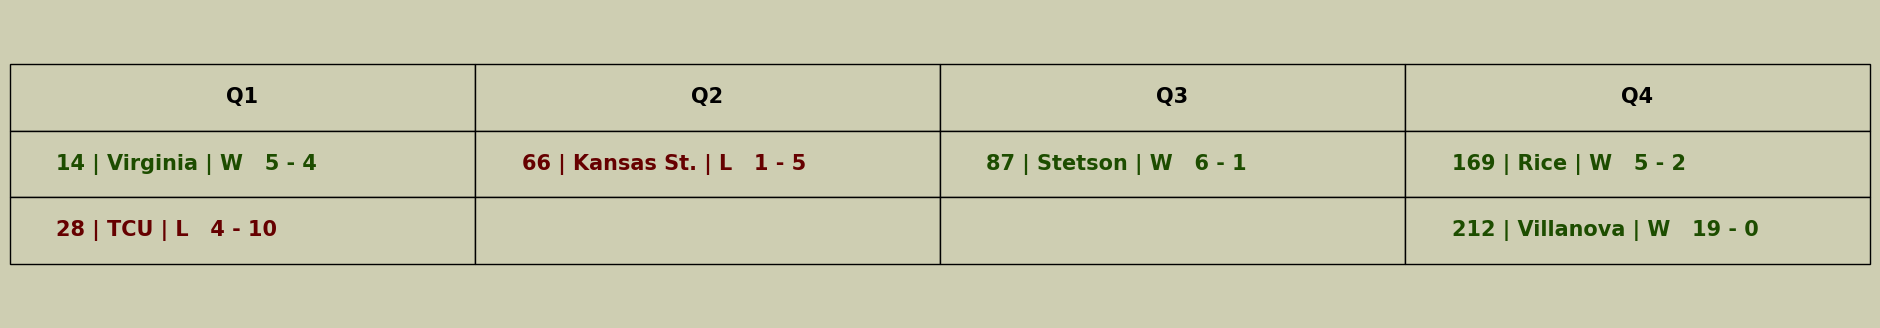

In [79]:
fig = create_quadrant_table(completed)

## Creating Bracket Based on NET

In [ ]:
import pandas as pd
import numpy as np
stats_and_metrics = pd.read_csv("./PEAR/PEAR Baseball/y2025/baseball_02_24_2025.csv")
automatic_qualifiers = stats_and_metrics.loc[stats_and_metrics.groupby("Conference")["NET"].idxmin()]
at_large = stats_and_metrics.drop(automatic_qualifiers.index)
at_large = at_large.nsmallest(34, "NET")
last_four_in = at_large[-4:].reset_index()
next_8_teams = stats_and_metrics.drop(automatic_qualifiers.index).nsmallest(42, "NET").iloc[34:].reset_index(drop=True)
tournament = pd.concat([at_large, automatic_qualifiers])
tournament = tournament.sort_values(by="NET").reset_index(drop=True)
tournament["Seed"] = (tournament.index // 16) + 1
pod_order = list(range(1, 17)) + list(range(16, 0, -1)) + list(range(1, 17)) + list(range(16, 0, -1))
tournament["Host"] = pod_order

In [56]:
# Create a new DataFrame where each Pod has 4 columns: "1 Seed", "2 Seed", "3 Seed", "4 Seed"
formatted_df = tournament.pivot_table(index="Host", columns="Seed", values="Team", aggfunc=lambda x: ' '.join(x))

# Rename the columns to match the desired format
formatted_df.columns = [f"{col} Seed" for col in formatted_df.columns]

# Reset index for better visualization (optional)
formatted_df = formatted_df.reset_index()
formatted_df['Host'] = formatted_df['1 Seed'].apply(lambda x: f"{x}")

# Set this new "Regional" column as the index
# formatted_df.set_index('Host')
formatted_df.index = formatted_df.index + 1
# formatted_df

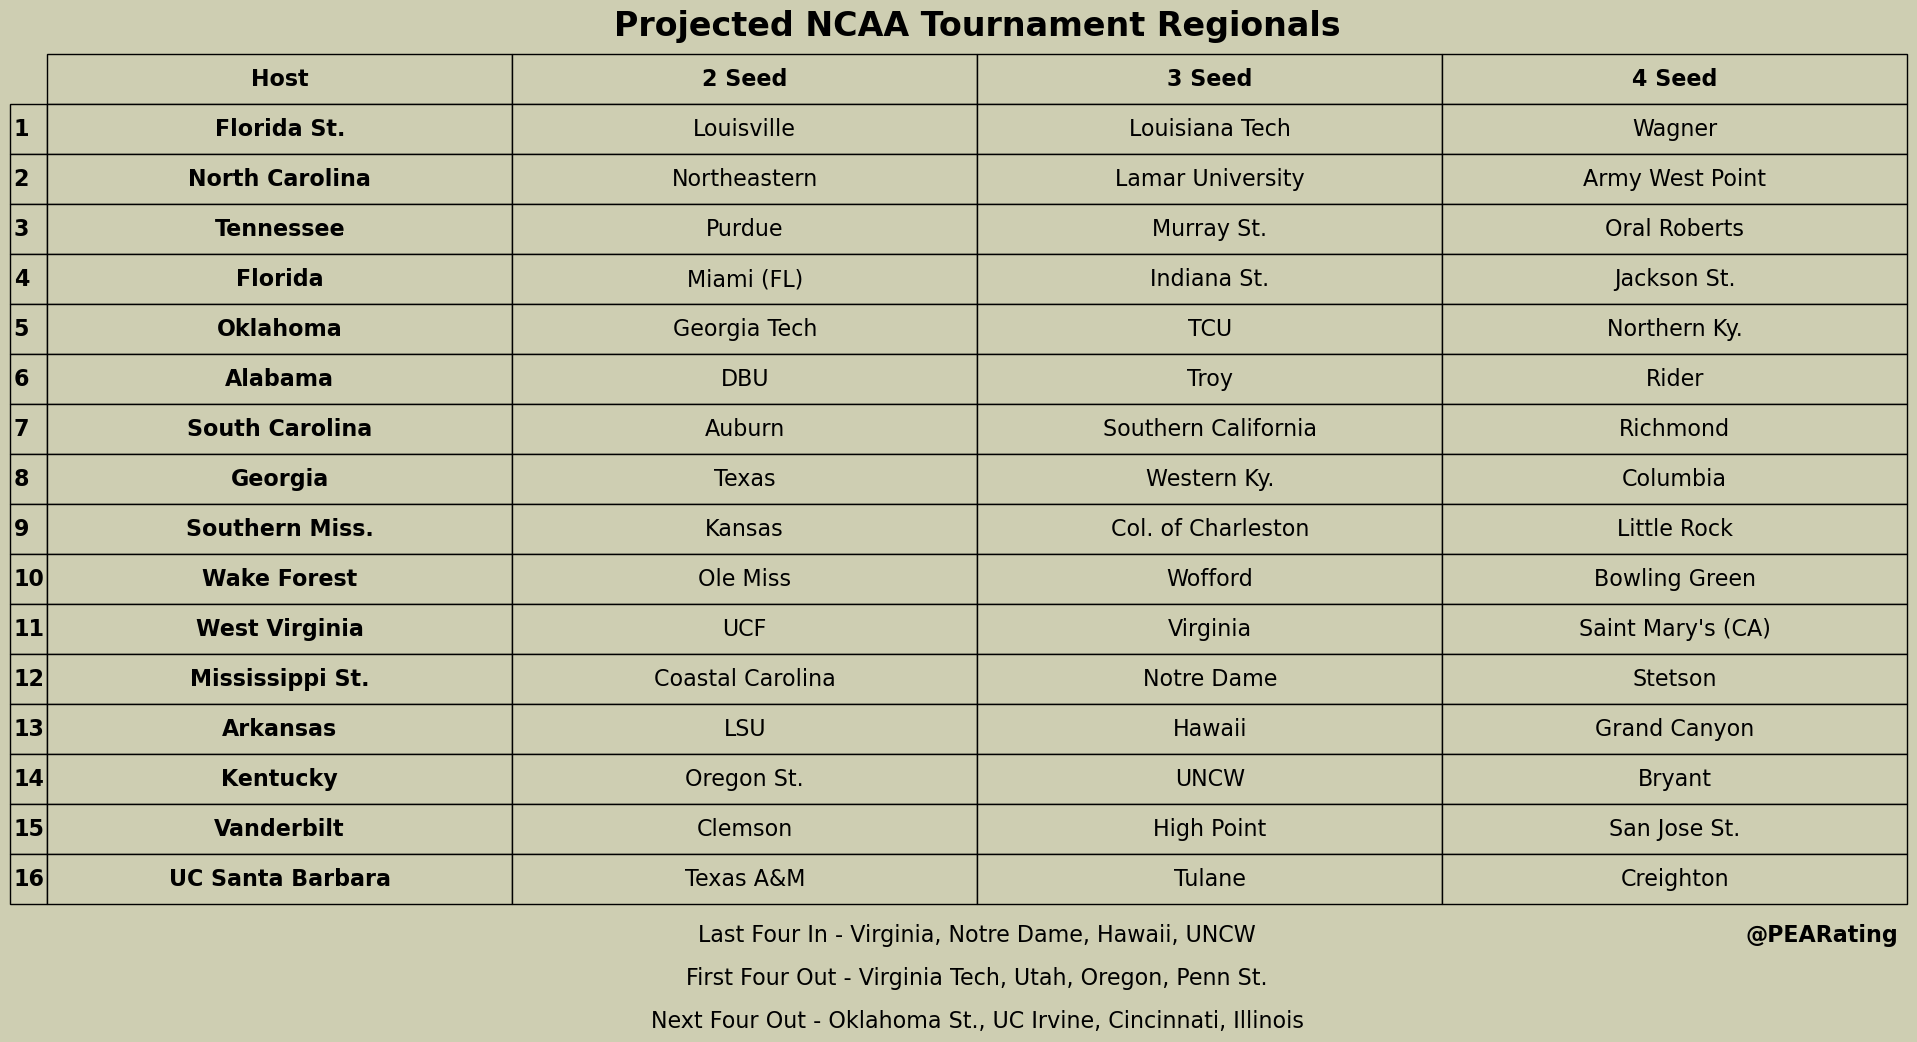

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), facecolor='#CECEB2')
ax = plt.gca()
ax.axis('off')
table = ax.table(cellText=formatted_df.iloc[:, 1:].values,
                rowLabels=formatted_df.index,
                colLabels=["Host", "2 Seed", "3 Seed", "4 Seed"],
                loc='center', cellLoc='center', colLoc='center')

# Customize the table style
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(2, 3)

# Make the row labels (index) and column labels bold
for (i, j), cell in table.get_celld().items():
    cell.set_facecolor('#CECEB2')
    if i == 0:  # Row label header
        cell.set_text_props(fontweight='bold')
    if (j == 0) | (j == -1):  # Column label header
        cell.set_text_props(fontweight='bold')

# Display the plot
plt.text(0.5,1.22, 'Projected NCAA Tournament Regionals', fontsize=24, ha='center', fontweight='bold')
plt.text(0.5, -0.25, f"Last Four In - {last_four_in.loc[0, 'Team']}, {last_four_in.loc[1, 'Team']}, {last_four_in.loc[2, 'Team']}, {last_four_in.loc[3, 'Team']}", ha='center', fontsize=16)
plt.text(0.5, -0.32, f"First Four Out - {next_8_teams.loc[0,'Team']}, {next_8_teams.loc[1,'Team']}, {next_8_teams.loc[2,'Team']}, {next_8_teams.loc[3,'Team']}", ha='center', fontsize=16)
plt.text(0.5, -0.39, f"Next Four Out - {next_8_teams.loc[4,'Team']}, {next_8_teams.loc[5,'Team']}, {next_8_teams.loc[6,'Team']}, {next_8_teams.loc[7,'Team']}", ha='center', fontsize=16)
plt.text(1.49, -0.25, "@PEARating", ha='right', fontsize=16, fontweight='bold')
plt.show()

In [76]:
next_8_teams.loc[0,'Team']

'Virginia Tech'

Data Dictionary

- G: Games
- AB: At Bats
- H: Hits
- BA: Batting Average
- HPG: Hits Per Game
- ABPG: At Bats Per Game
- HPAB: Hits Per At Bat
- BB: Walks
- BBPG: Walks Per Game
- DP: Double Plays
- DPPG: Double Plays Per Game
- IP: Innings Pitched
- RA: Runs Allowed
- ER: Earned Runs
- ERA: Earned Runs Allowed
- PO: Put Outs
- A: Assists
- E: Errors
- PCT: Fielding Percentage
- APG: Assists Per Game
- EPG: Errors Per Game
- HA: Hits Allowed
- HAPG: Hits Allowed Per Game
- HR: Home Runs Hit
- HRPG: Home Runs Hit Per Game
- HBP: Hit By Pitch
- OBP: On Base Percentage
- HBPPG: Hit By Pitch Per Game
- RS: Runs Scored
- RPG: Runs Scored Per Game
- SB: Sacrifice Bunts
- SBPG: Sacrifice Bunts Per Game
- SF: Sacrifice Flies
- SFPG: Sacrifice Flies Per Game
- TB: Total Bases
- SLG: Slugging Percentage
- STL: Stolen Bases
- CS: Caught Stealing
- STLP: Stolen Bases Success Percentage
- STLPG: Stolen Bases Per Game
- CSPG: Caught Stealing Per Game
- SAPG: Stealing Attempts Per Game
- SO: Pitching Strike Outs
- PBB: Pitching Walks
- KBB: Strikeouts to Walk Ratio
- KP9: Strikeouts Per Nine
- WP9: Walks Allowed Per Nine
- WHIP: Walks Hits Over Innings Pitched

In [ ]:
# # Scrape all stats at once
# for stat_name, url in stat_links.items():
#     print(f"Scraping: {stat_name} ({url})")
    
#     # Get stats page content
#     soup = get_soup(url)
    
#     # Locate table
#     table = soup.find("table")
#     if not table:
#         print(f"No table found for {stat_name}")
#         continue

#     # Extract table headers
#     headers = [th.text.strip() for th in table.find_all("th")]

#     # Extract table rows
#     data = []
#     for row in table.find_all("tr")[1:]:  # Skip header row
#         cols = row.find_all("td")
#         data.append([col.text.strip() for col in cols])

#     # Convert to DataFrame and save
#     df = pd.DataFrame(data, columns=headers)
#     # df.to_csv(f"{stat_name}.csv", index=False)
#     print(f"Saved {stat_name}.csv")

# print("Scraping completed!")